The aim of this project is to create a LSTM capable of predicting next-day share price increases, for the ASX Schools Sharemarket game.


In [2]:
import pandas as pd

In [3]:
%%script echo "Skipping Execution"

import yfinance as yf

stocks = pd.read_csv("./stocks.tsv", sep="\t")["SYMBOL"].to_list()
stocks = [f"{stock}.AX" for stock in stocks]

data = yf.download(stocks, period="6mo")["Close"]

data.to_csv("./data/stock_values.csv")

Skipping Execution


### Preparing the data.

Data is squished into a long dataset, before moving averages are added, null rows are dropped and the stock category is encoded.


In [4]:
all_data = pd.read_csv("./data/stock_values.csv")

# Reshape the dataframe from wide to long format, with each row representing a unique date-stock combination and its corresponding closing price.
all_data = all_data.melt(id_vars="Date", var_name="Stock", value_name="Close")

all_data = all_data.drop(columns=["Date"])
all_data["MA_5"] = all_data.groupby("Stock")["Close"].transform(
    lambda x: x.rolling(5).mean()
)
all_data["MA_10"] = all_data.groupby("Stock")["Close"].transform(
    lambda x: x.rolling(10).mean()
)
all_data["MA_20"] = all_data.groupby("Stock")["Close"].transform(
    lambda x: x.rolling(20).mean()
)

all_data.sample(10, random_state=42)

,Stock,Close,MA_5,MA_10,MA_20
24985,ORI.AX,18.740000,18.602,18.419000,18.2350
19125,LOV.AX,20.639999,NaN,NaN,NaN
3077,ARG.AX,8.760000,8.794,8.808000,8.8090
24526,ORA.AX,2.650000,2.638,2.620000,2.6055
32428,TCL.AX,13.470000,13.292,13.132000,13.2120
2847,ARB.AX,37.849998,38.338,38.387001,39.0350
6747,CCP.AX,14.290000,14.520,14.417000,14.6735
35091,VOC.AX,NaN,NaN,NaN,NaN
21693,MTS.AX,3.910000,3.938,3.857000,3.7605
1133,ALD.AX,35.529999,35.324,NaN,NaN


In [5]:
# normalise data for each stock


def normalise_data(df: pd.DataFrame):
    """This function normalises stock data IN PLACE. Assumes `Close`, `MA_5`, `MA_10`, and `MA_20` columns are present."""

    df[["Close", "MA_5", "MA_10", "MA_20"]] = df.groupby("Stock")[
        ["Close", "MA_5", "MA_10", "MA_20"]
    ].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [6]:
normalise_data(all_data)

# print("Before Dropna: ", all_data.shape)
all_data = all_data.dropna()
# print("After Dropna: ", all_data.shape)

one_hot = pd.get_dummies(all_data["Stock"])

all_data = pd.concat([all_data, one_hot], axis=1)
# Don't drop Stock just yet. It makes the logic easier later.
# all_data = all_data.drop(columns=["Stock"])

# print(all_data.describe())

all_data

,Stock,Close,MA_5,MA_10,MA_20,A200.AX,A2M.AX,AAA.AX,ABC.AX,AFI.AX,...,WGX.AX,WHC.AX,WLE.AX,WOR.AX,WOW.AX,WPR.AX,WTC.AX,XRO.AX,YAL.AX,ZIM.AX
19,A200.AX,0.297922,0.380515,0.354623,0.000000,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20,A200.AX,0.388761,0.349721,0.348189,0.039956,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21,A200.AX,0.321786,0.334414,0.331744,0.069468,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
22,A200.AX,0.375673,0.339636,0.311249,0.104280,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23,A200.AX,0.345650,0.339636,0.273355,0.130944,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37495,ZIM.AX,0.195313,0.182215,0.128934,0.040162,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
37496,ZIM.AX,0.171875,0.181544,0.135193,0.044121,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
37497,ZIM.AX,0.146875,0.176174,0.136087,0.045569,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
37498,ZIM.AX,0.146875,0.165772,0.132332,0.045279,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

In [8]:
WINDOW_SIZE = 10

X, y = [], []

for ticker in all_data["Stock"].unique():
    stock_data = all_data[all_data["Stock"] == ticker]
    for i in range(len(stock_data) - WINDOW_SIZE):
        X.append(stock_data.iloc[i : i + WINDOW_SIZE, 1:].values)  # Previous 10 days
        y.append(stock_data.iloc[i + WINDOW_SIZE, 1:])  # Next day's data

X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

In [9]:
X_train.shape, X_train.dtype  # (number of samples, window size, number of features)

((20206, 10, 268), dtype('float32'))

The data is now ready.

We construct an LSTM with PyTorch as follows:


In [10]:
import torch
import torch.nn as nn

In [11]:
device = torch.device("cpu")

if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")

Using MPS


In [12]:
class OtwayModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(OtwayModel, self).__init__()
        self.lstm = nn.LSTM(input_size, 64, 2, batch_first=True)
        self.fc = nn.Linear(64, output_size)  # arbitrary

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

In [13]:
model = OtwayModel(X_train.shape[2], y_train.shape[1]).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [14]:
X_train_tensor = torch.tensor(X_train, device=device)
y_train_tensor = torch.tensor(y_train, device=device)

In [15]:
for epoch in range(100):
    model.train()
    optimiser.zero_grad()
    output = model(X_train_tensor)
    loss = loss_fn(output, y_train_tensor)
    loss.backward()
    optimiser.step()
    print(f"Epoch {epoch}: Loss {loss.item()}")

Epoch 0: Loss 0.016145091503858566
Epoch 1: Loss 0.015105636790394783
Epoch 2: Loss 0.014266790822148323
Epoch 3: Loss 0.013570548966526985
Epoch 4: Loss 0.012971866875886917
Epoch 5: Loss 0.012439779005944729
Epoch 6: Loss 0.011953137814998627
Epoch 7: Loss 0.01149698905646801
Epoch 8: Loss 0.011060790158808231
Epoch 9: Loss 0.010637596249580383
Epoch 10: Loss 0.010223760269582272
Epoch 11: Loss 0.009818862192332745
Epoch 12: Loss 0.009425411000847816
Epoch 13: Loss 0.009047996252775192
Epoch 14: Loss 0.00869158934801817
Epoch 15: Loss 0.008358767256140709
Epoch 16: Loss 0.008047092705965042
Epoch 17: Loss 0.007749356795102358
Epoch 18: Loss 0.007458195555955172
Epoch 19: Loss 0.0071714031510055065
Epoch 20: Loss 0.00689349789172411
Epoch 21: Loss 0.006631999276578426
Epoch 22: Loss 0.006391766015440226
Epoch 23: Loss 0.006172639783471823
Epoch 24: Loss 0.0059712789952754974
Epoch 25: Loss 0.005784447304904461
Epoch 26: Loss 0.005610540974885225
Epoch 27: Loss 0.005448373965919018
Epo

In [16]:
X_test_tensor = torch.tensor(X_test, device=device)
y_test_tensor = torch.tensor(y_test, device=device)

In [17]:
import matplotlib.pyplot as plt

In [18]:
model.eval()

OtwayModel(
  (lstm): LSTM(268, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=268, bias=True)
)

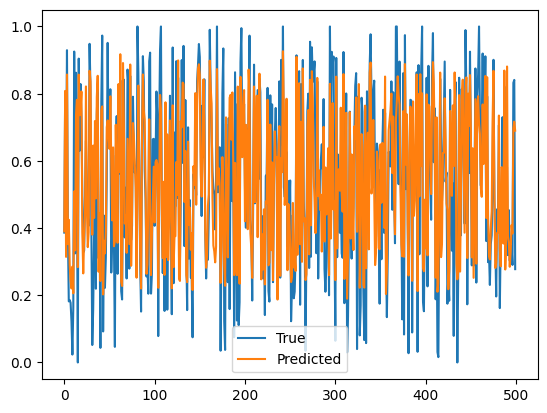

In [19]:
# Make test predictions and plot

with torch.no_grad():
    y_pred = model(X_test_tensor)

y_pred = y_pred.cpu().numpy()

plt.plot(y_test[:200, 0], label="True")
plt.plot(y_pred[:200, 0], label="Predicted")

plt.legend()
plt.show()

In [20]:
# Save the model.

torch.save(model.state_dict(), "./model/otway_model.pt")